In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import h5py
import os
import time
import pickle
import pandas as pd
from sklearn.cluster import KMeans

from sceb.util import *
import sceb.data_loader as dl
import sceb.scdd as sd
import sceb.scdd_extra as sde
import scanpy.api as sc

%matplotlib inline
%load_ext autoreload
%autoreload 2

from matplotlib import rcParams

params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 10,
   'xtick.labelsize': 13,
   'ytick.labelsize': 13,
   'text.usetex': False,
   'text.usetex': False,
   }
rcParams.update(params)

/home/martin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Import data

In [2]:
input_folder = '/data/martin/single_cell/smfish_celseq/'
file_celseq = input_folder + 'GSE54695_data_transcript_counts.txt'
folder_smFISH = input_folder + 'smFISH_counts'
# Import cel-seq data
df_celseq = pd.read_table(file_celseq, delimiter='\t')
df_celseq = df_celseq.set_index('GENENAME')
df_celseq = pd.DataFrame.transpose(df_celseq)
# smFISH data
file_list = os.listdir(folder_smFISH)
sm_FISH_2i_dic = {}
sm_FISH_s_dic = {}
for fname in file_list:
    fpath = folder_smFISH + '/' + fname
    df_temp = pd.read_table(fpath, delimiter='\t')
    gene_name = df_temp.columns[0]
    data = df_temp[gene_name].as_matrix()
    if '2i' in fname:
        sm_FISH_2i_dic[gene_name] = data
    else:
        sm_FISH_s_dic[gene_name] = data
gene_list = list(sm_FISH_2i_dic.keys())
n_gene = len(gene_list)
output_folder = '/home/martin/single_cell_eb/figures/figure_smfish'

# Estimation

In [3]:
# Estimation for cel-seq
df_celseq_2i = df_celseq.loc[['%s_%d'%('SC_2i',x+1) for x in range(80)]]
lib_size = np.array(df_celseq_2i.sum(axis=1))
ind_select = lib_size>500
lib_size = lib_size[ind_select]
size_factor = lib_size/np.mean(lib_size)
cv_celseq_ml = np.zeros([n_gene], dtype=float)
cv_celseq_dd = np.zeros([n_gene], dtype=float)
p0_celseq_ml = np.zeros([n_gene], dtype=float)
p0_celseq_dd = np.zeros([n_gene], dtype=float)
for i_gene,gene in enumerate(gene_list):
    # cv
    temp = df_celseq_2i[gene].as_matrix()
    temp = temp[ind_select]
    cv_ml,cv_dd = sde.cv_single(temp, size_factor=size_factor)
    cv_celseq_ml[i_gene] = cv_ml
    cv_celseq_dd[i_gene] = cv_dd
    print('%s, mean=%0.2f, ml=%0.4f, dd=%0.4f'%(gene,np.mean(temp),cv_ml,cv_dd))
    # p0
    p0_ml, p0_dd = sde.p0_single(temp.astype(int), size_factor=size_factor,
                                 relative_depth=0.4)
    print(p0_ml, p0_dd)
    p0_celseq_ml[i_gene] = p0_ml
    p0_celseq_dd[i_gene] = p0_dd
print('')


Klf4, mean=13.87, ml=0.5906, dd=0.6531
0.02631578947368421 0.0
Sox2, mean=16.66, ml=0.4614, dd=0.2216
0.0 0.0
Pou5f1, mean=47.09, ml=0.2331, dd=0.2621
0.0 0.0
Sohlh2, mean=0.50, ml=1.7567, dd=0.9289
0.6973684210526317 0.5922518100351483
Pcna, mean=15.27, ml=0.4190, dd=0.2360
0.0 0.028075726393134125
Stag3, mean=1.28, ml=1.2474, dd=0.6466
0.4210526315789472 0.09698187526200006
Gli2, mean=0.93, ml=1.3845, dd=0.4491
0.4868421052631576 0.14965463126934658
Notch1, mean=0.86, ml=1.4483, dd=0.3492
0.47368421052631565 0.2575453374084128
Tpx2, mean=6.19, ml=0.7333, dd=0.7145
0.07894736842105263 0.30652144033828904



In [4]:
# Estimation for smFISH
gene_anchor = 'Pcna'
size_moment_2i = np.zeros([2], dtype=float)
temp = sm_FISH_2i_dic[gene_anchor]
percent_min, percent_max = np.percentile(temp, [2.5, 97.5])
temp = temp[(temp>=percent_min)&(temp<=percent_max)]
temp = temp/np.mean(temp)
size_moment_2i[0] = np.mean(temp)
size_moment_2i[1] = np.mean(temp**2)
cv_fish_2i = np.zeros([n_gene], dtype=float)
ind_bad_2i = np.zeros([n_gene], dtype=bool)
p0_fish= np.zeros([n_gene], dtype=float)-1
for i_gene,gene in enumerate(gene_list):
    # CV estimation
    temp_ct = sm_FISH_2i_dic[gene]
    cv_fish_2i[i_gene] = sde.cv_single_fish(temp_ct, size_moment=size_moment_2i)
    print('2i: %s, mean=%0.4f, cv_fish=%0.4f'%(gene, np.mean(temp_ct), cv_fish_2i[i_gene]))
    # P0
    temp_celseq = df_celseq_2i[gene].as_matrix()
    temp_celseq = temp_celseq[ind_select]
    temp_sub,_,success_flag = sde.subsample_single_gene(temp_ct, temp_celseq.shape[0], 
                                                        int(np.sum(temp_celseq)*2.5),
                                                        random_state=0)
    if success_flag:
        p0_fish[i_gene] = np.mean(temp_sub==0)


2i: Klf4, mean=62.4072, cv_fish=0.5014
2i: Sox2, mean=120.6765, cv_fish=0.3415
2i: Pou5f1, mean=302.8323, cv_fish=0.2267
2i: Sohlh2, mean=14.3005, cv_fish=0.6806
2i: Pcna, mean=190.7517, cv_fish=0.1500
2i: Stag3, mean=12.2624, cv_fish=0.5888
2i: Gli2, mean=11.0090, cv_fish=0.6502
2i: Notch1, mean=12.5351, cv_fish=0.5414
2i: Tpx2, mean=45.9329, cv_fish=0.6178


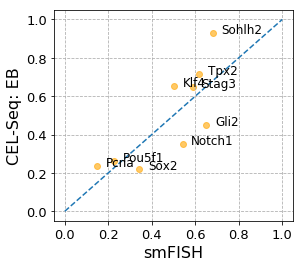

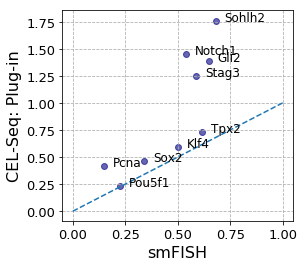

In [6]:
plt.figure(figsize=[4.5,4])
plt.scatter(cv_fish_2i[~ind_bad_2i], cv_celseq_dd[~ind_bad_2i], color='orange', alpha=0.6)
for i_gene,gene in enumerate(gene_list):
    if ~ind_bad_2i[i_gene]:
        plt.annotate(gene_list[i_gene],
                     (cv_fish_2i[i_gene]+0.04,
                      cv_celseq_dd[i_gene]),
                     fontsize=12)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('smFISH')
plt.ylabel('CEL-Seq: EB')
plt.grid(linestyle='--')
plt.tight_layout()
plt.savefig(output_folder + '/cv_celseq_eb.pdf')
plt.show()
plt.figure(figsize=[4.5,4])
plt.scatter(cv_fish_2i[~ind_bad_2i], cv_celseq_ml[~ind_bad_2i], color='navy', alpha=0.6)
for i_gene,gene in enumerate(gene_list):
    if ~ind_bad_2i[i_gene]:
        plt.annotate(gene_list[i_gene],
                     (cv_fish_2i[i_gene]+0.04,
                      cv_celseq_ml[i_gene]),
                     fontsize=12)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('smFISH')
plt.ylabel('CEL-Seq: Plug-in')
plt.grid(linestyle='--')
plt.tight_layout()
plt.savefig(output_folder + '/cv_celseq_plugin.pdf')
plt.show()

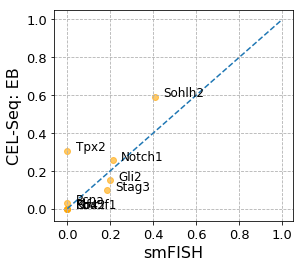

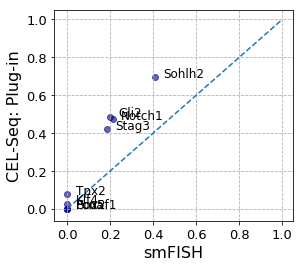

In [8]:
plt.figure(figsize=[4.5,4])
# plt.subplot(121)
plt.scatter(p0_fish[~ind_bad_2i], p0_celseq_dd[~ind_bad_2i], color='orange', alpha=0.6)
for i_gene,gene in enumerate(gene_list):
    if ~ind_bad_2i[i_gene]:
        plt.annotate(gene_list[i_gene],
                     (p0_fish[i_gene]+0.04,
                      p0_celseq_dd[i_gene]),
                     fontsize=12)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('smFISH')
plt.ylabel('CEL-Seq: EB')
plt.grid(linestyle='--')
plt.tight_layout()
plt.savefig(output_folder + '/p0_celseq_eb.pdf')
# plt.subplot(122)
plt.figure(figsize=[4.5,4])
plt.scatter(p0_fish, p0_celseq_ml[~ind_bad_2i], color='navy', alpha=0.6)
for i_gene,gene in enumerate(gene_list):
    if ~ind_bad_2i[i_gene]:
        plt.annotate(gene_list[i_gene],
                     (p0_fish[i_gene]+0.04,
                      p0_celseq_ml[i_gene]),
                     fontsize=12)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('smFISH')
plt.ylabel('CEL-Seq: Plug-in')
plt.grid(linestyle='--')
plt.tight_layout()
plt.savefig(output_folder + '/p0_celseq_plugin.pdf')
plt.show()

# Debug

## Estimation

In [6]:
# Estimation for cel-seq
cv_celseq = {}
p0_celseq = {}
p0_fish = {}
for dtype in ['SC_2i', 'RNA_2i', 'SC_serum', 'RNA_serum']:
    print('## %s'%dtype)
    temp_df = df_celseq.loc[['%s_%d'%(dtype,x+1) for x in range(80)]]
    lib_size = np.array(temp_df.sum(axis=1))
    ind_select = lib_size>500
    lib_size = lib_size[ind_select]
    size_factor = lib_size/np.mean(lib_size)
    cv_temp_ml = np.zeros([n_gene], dtype=float)
    cv_temp_dd = np.zeros([n_gene], dtype=float)
    p0_temp_ml = np.zeros([n_gene], dtype=float)
    p0_temp_dd = np.zeros([n_gene], dtype=float)
    temp_p0_fish = np.zeros([n_gene], dtype=float)
    for i_gene,gene in enumerate(gene_list):
        # cv
        temp = temp_df[gene].as_matrix()
        temp = temp[ind_select]
        cv_ml,cv_dd = sde.cv_single(temp, size_factor=size_factor)
        cv_temp_ml[i_gene] = cv_ml
        cv_temp_dd[i_gene] = cv_dd
        print('%s, mean=%0.2f, ml=%0.4f, dd=%0.4f'%(gene,np.mean(temp),cv_ml,cv_dd))
        # p0
        p0_ml, p0_dd = sde.p0_single(temp, size_factor=size_factor, relative_depth=0.5)
        p0_temp_ml[i_gene] = p0_ml
        p0_temp_dd[i_gene] = p0_dd
        # p0 fish
        
    cv_celseq[dtype] = {}
    cv_celseq[dtype]['plug-in'] = cv_temp_ml
    cv_celseq[dtype]['eb'] = cv_temp_dd
    cv_celseq[dtype]['p0_plug-in'] = p0_temp_ml
    cv_celseq[dtype]['p0_eb'] = p0_temp_dd
    print('')
    
    
    dtype = 'SC_serum'
    temp_df = df_celseq.loc[['%s_%d'%(dtype,x+1) for x in range(80)]]
    temp_sub,_,success_flag = sde.subsample_single_gene(temp_ct, n_cell, 
                                                        int(n_cell),
                                                        random_state=0)
    if success_flag:
        p0_fish_s[i_gene] = np.mean(temp_sub==0)

## SC_2i
Klf4, mean=13.87, ml=0.5906, dd=0.6531
Sox2, mean=16.66, ml=0.4614, dd=0.2216
Pou5f1, mean=47.09, ml=0.2331, dd=0.2621
Sohlh2, mean=0.50, ml=1.7567, dd=0.9289
Pcna, mean=15.27, ml=0.4190, dd=0.2360
Stag3, mean=1.28, ml=1.2474, dd=0.6466
Gli2, mean=0.93, ml=1.3845, dd=0.4491
Notch1, mean=0.86, ml=1.4483, dd=0.3492
Tpx2, mean=6.19, ml=0.7333, dd=0.7145

## RNA_2i
Klf4, mean=22.35, ml=0.2757, dd=0.2305
Sox2, mean=25.48, ml=0.2674, dd=0.1352
Pou5f1, mean=54.38, ml=0.1672, dd=0.1325
Sohlh2, mean=1.03, ml=0.8904, dd=0.0000
Pcna, mean=21.28, ml=0.2221, dd=0.0858
Stag3, mean=2.35, ml=0.6766, dd=0.3509
Gli2, mean=1.42, ml=0.9366, dd=0.3539
Notch1, mean=1.05, ml=1.2924, dd=0.8162
Tpx2, mean=6.60, ml=0.4402, dd=0.3298

## SC_serum
Klf4, mean=14.04, ml=0.8058, dd=0.5067
Sox2, mean=15.32, ml=0.9540, dd=0.4607
Pou5f1, mean=48.12, ml=0.7092, dd=0.4768
Sohlh2, mean=0.35, ml=3.0263, dd=1.9348
Pcna, mean=13.40, ml=0.8796, dd=0.4468
Stag3, mean=0.89, ml=1.3705, dd=0.2167
Gli2, mean=0.70, ml=2.75

In [4]:
# Estimation for smFISH
# Size moment: serum
gene_anchor = 'Pcna'
size_moment_s = np.zeros([2], dtype=float)
temp = sm_FISH_s_dic[gene_anchor]
percent_min, percent_max = np.percentile(temp, [1.5, 98.5])
temp = temp[(temp>=percent_min)&(temp<=percent_max)]
temp = temp/np.mean(temp)
size_moment_s[0] = np.mean(temp)
size_moment_s[1] = np.mean(temp**2)
# Size moment: 2i
size_moment_2i = np.zeros([2], dtype=float)
temp = sm_FISH_2i_dic[gene_anchor]
percent_min, percent_max = np.percentile(temp, [2.5, 97.5])
temp = temp[(temp>=percent_min)&(temp<=percent_max)]
temp = temp/np.mean(temp)
size_moment_2i[0] = np.mean(temp)
size_moment_2i[1] = np.mean(temp**2)
cv_fish_s = np.zeros([n_gene], dtype=float)
cv_fish_2i = np.zeros([n_gene], dtype=float)
ind_bad_s = np.zeros([n_gene], dtype=bool)
ind_bad_2i = np.zeros([n_gene], dtype=bool)
# CV estimation
for i_gene,gene in enumerate(gene_list):
    # Serum
    temp_ct = sm_FISH_s_dic[gene]
    cv_fish = sde.cv_single_fish(temp_ct, size_moment=size_moment_s)
    cv_fish_s[i_gene] = cv_fish
    print('serum: %s, mean=%0.4f, cv_fish=%0.4f'%(gene, np.mean(temp_ct), cv_fish))
    # 2i
    temp_ct = sm_FISH_2i_dic[gene]
    cv_fish = sde.cv_single_fish(temp_ct, size_moment=size_moment_2i)
    cv_fish_2i[i_gene] = cv_fish
    print('2i: %s, mean=%0.4f, cv_fish=%0.4f'%(gene, np.mean(temp_ct), cv_fish))
    print('')

serum: Klf4, mean=91.0460, cv_fish=0.4511
2i: Klf4, mean=62.4072, cv_fish=0.5014

serum: Sox2, mean=120.6267, cv_fish=0.3693
2i: Sox2, mean=120.6765, cv_fish=0.3415

serum: Pou5f1, mean=457.9310, cv_fish=0.3934
2i: Pou5f1, mean=302.8323, cv_fish=0.2267

serum: Sohlh2, mean=13.3958, cv_fish=0.7049
2i: Sohlh2, mean=14.3005, cv_fish=0.6806

serum: Pcna, mean=178.3229, cv_fish=0.2433
2i: Pcna, mean=190.7517, cv_fish=0.1500

serum: Stag3, mean=20.6710, cv_fish=0.5541
2i: Stag3, mean=12.2624, cv_fish=0.5888

serum: Gli2, mean=15.2516, cv_fish=0.5537
2i: Gli2, mean=11.0090, cv_fish=0.6502

serum: Notch1, mean=422.0980, cv_fish=0.1482
2i: Notch1, mean=12.5351, cv_fish=0.5414

serum: Tpx2, mean=63.5000, cv_fish=0.5108
2i: Tpx2, mean=45.9329, cv_fish=0.6178



In [5]:
# Eliminate bad genes
ind_bad_s = np.zeros([n_gene], dtype=bool)
ind_bad_2i = np.zeros([n_gene], dtype=bool)
for i_gene,gene in enumerate(gene_list):
    if gene == gene_anchor:
        ind_bad_s[i_gene] = True
        ind_bad_2i[i_gene] = True
    if gene == 'Sohlh2':
        ind_bad_s[i_gene] = True
#     temp_ct = df_celseq.loc[['%s_%d'%('SC_serum',x+1) for x in range(80)]][gene].as_matrix()
#     if temp_ct.mean()<0.2:
#         ind_bad_s[i_gene] = True
#     temp_ct = df_celseq.loc[['%s_%d'%('SC_2i',x+1) for x in range(80)]][gene].as_matrix()
#     if temp_ct.mean()<0.2:
#         ind_bad_2i[i_gene] = True

## Generate consistency plot

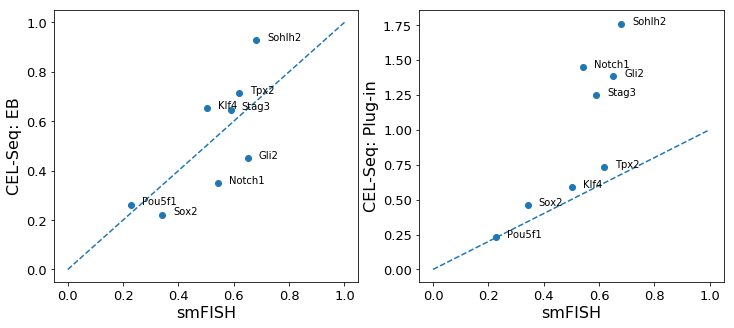

In [6]:
plt.figure(figsize=[12,5])
plt.subplot(121)
plt.scatter(cv_fish_2i[~ind_bad_2i], cv_celseq['SC_2i']['eb'][~ind_bad_2i])
for i_gene,gene in enumerate(gene_list):
    if ~ind_bad_2i[i_gene]:
        plt.annotate(gene_list[i_gene],
                     (cv_fish_2i[i_gene]+0.04,
                      cv_celseq['SC_2i']['eb'][i_gene]),
                     fontsize=10)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('smFISH')
plt.ylabel('CEL-Seq: EB')
plt.subplot(122)
plt.scatter(cv_fish_2i[~ind_bad_2i], cv_celseq['SC_2i']['plug-in'][~ind_bad_2i])
for i_gene,gene in enumerate(gene_list):
    if ~ind_bad_2i[i_gene]:
        plt.annotate(gene_list[i_gene],
                     (cv_fish_2i[i_gene]+0.04,
                      cv_celseq['SC_2i']['plug-in'][i_gene]),
                     fontsize=10)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('smFISH')
plt.ylabel('CEL-Seq: Plug-in')
plt.show()

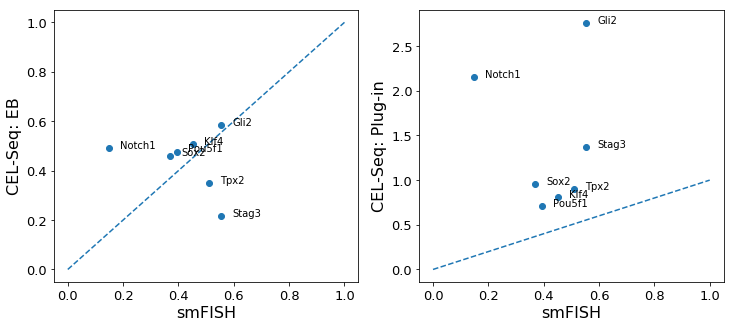

In [7]:
plt.figure(figsize=[12,5])
plt.subplot(121)
plt.scatter(cv_fish_s[~ind_bad_s], cv_celseq['SC_serum']['eb'][~ind_bad_s])
for i_gene,gene in enumerate(gene_list):
    if ~ind_bad_s[i_gene]:
        plt.annotate(gene_list[i_gene],
                     (cv_fish_s[i_gene]+0.04,
                      cv_celseq['SC_serum']['eb'][i_gene]),
                     fontsize=10)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('smFISH')
plt.ylabel('CEL-Seq: EB')
plt.subplot(122)
plt.scatter(cv_fish_s[~ind_bad_s], cv_celseq['SC_serum']['plug-in'][~ind_bad_s])
for i_gene,gene in enumerate(gene_list):
    if ~ind_bad_s[i_gene]:
        plt.annotate(gene_list[i_gene],
                     (cv_fish_s[i_gene]+0.04,
                      cv_celseq['SC_serum']['plug-in'][i_gene]),
                     fontsize=10)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('smFISH')
plt.ylabel('CEL-Seq: Plug-in')
plt.show()